In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee

### Power spectral density

Text(0, 0.5, 'Power Spectrum Density')

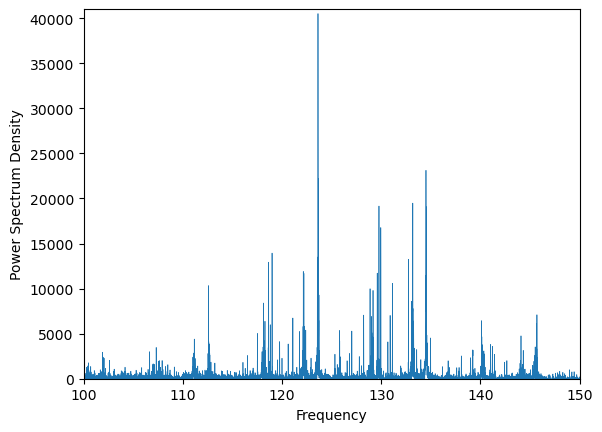

In [2]:
file = 'power_filtered006144777.dat'
load = np.loadtxt(file)
freq = load[:,0]
power = load[:,1]

# plt.figure(2/, figsize=(10, 6))
plt.plot(freq, power, lw=0.5)
plt.xlim(100, 150)
plt.ylim(0, 41e3)
plt.xlabel("Frequency")
plt.ylabel("Power Spectrum Density")

### Initial values of $\alpha$, $\epsilon$, $\Delta\nu$ and $\nu_{max}$

In [3]:
alpha = 0.0073
epsilon = 1.197
delta_nu = 11.033
numax = 128.40
n=10


In [4]:
# def lorentzian(frequency, H, nu_center, Gamma):
#     return H / (1 + 4 * ((frequency - nu_center) / Gamma)**2)

# def lorentzian_model(nu, H_l0, H_l2, gamma_l0, gamma_l2, d0l):
#     # Calculate nu_center using the full asymptotic formula for l=0 and l=2
#     n_max = numax / delta_nu - epsilon
#     # n_radial_l0 = n_radial + 1
#     nu_center1 = ((n + 1 + 0 / 2 + epsilon + 0 + alpha / 2 * (n + 1 - n_max)**2) * delta_nu)  # l=0
#     nu_center2 = ((n + 2 / 2 + epsilon + d0l + alpha / 2 * (n - n_max)**2) * delta_nu)  # l=2
#     return (lorentzian(nu, H_l0, nu_center1, gamma_l0) +
#             lorentzian(nu, H_l2, nu_center2, gamma_l2))

### Asymptotic expansion and Lorentzian profile

In [5]:
def asymptotic_expansion(n, l, d_0l):
    nmax = numax/delta_nu - epsilon
    nu_nl = (n+l/2+epsilon+d_0l+alpha/2*(n-nmax)**2)*delta_nu
    return nu_nl

In [6]:
def lorentzian_model(nu, H_l0, H_l2, gamma_l0, gamma_l2, d0l):
    model_l0 = H_l0/(1+4/(gamma_l0**2)*(nu - asymptotic_expansion(n,0,0))**2)
    model_l2 = H_l2/(1+4/(gamma_l2**2)*(nu - asymptotic_expansion(n-1, 2, d0l))**2)
    return model_l0 + model_l2

### Bayesian framework

In [7]:
def log_likelihood(params, nu, power_density):
    H_l0, H_l2, gamma_l0, gamma_l2, d0l = params
    model = lorentzian_model(nu, H_l0, H_l2, gamma_l0, gamma_l2, d0l)
    return - np.sum((np.log(model)+ power_density/model))

# Log-prior function
def log_prior(params):
    H_l0, H_l2, gamma_l0, gamma_l2, d0l = params
# H_l0 = 1e4
# H_l2 = 5e3
# gamma_l0 = 0.05
# gamma_l2 = 0.05
# d0l = -0.13
    if 5000 < H_l0 < 50000 and 1000 < H_l2 < 20000 and 0.01 < gamma_l0 < 2 and 0.01 < gamma_l2 < 2 and -2 < d0l < -0.01:
        return 0.0  # Uniform prior
    return -np.inf  # Invalid prior

# Combined log-probability function
def log_probability(params, nu, power_density):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, nu, power_density)

### Initial guess for MCMC

In [8]:
#Initial guess
H_l0 = 40000
H_l2 = 15000
gamma_l0 = 0.5
gamma_l2 = 1
d0l = -1

data = (freq[(freq>120) & (freq<127)], power[(freq>120) & (freq<127)])
initial = np.array([H_l0, H_l2, gamma_l0, gamma_l2, d0l])
nwalkers = 64
ndim = len(initial)
nsteps =100000
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim) * initial



In [9]:
# n= 10
# model = lorentzian_model(freq, H_l0, H_l2, gamma_l0, gamma_l2, d0l)
# plt.plot(freq, power)
# plt.plot(freq, model)
# plt.xlim(100, 150)
# plt.ylim(0, 45e3)


### Initialising MCMC

In [ ]:
#Initialise MCMC
n=8
sampler  = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=data)
sampler.run_mcmc(pos, nsteps, progress=True)
# Analyze results``
samples = sampler.get_chain(discard=6000, flat=True)
#print(samples.shape)
best_theta = np.median(samples, axis=0)
print(best_theta, n)

100%|██████████| 100000/100000 [03:07<00:00, 533.34it/s]


[ 5.00000000e+03  1.00000001e+03  1.00000000e-02  1.00000001e-02
 -1.99999999e+00] 10


In [11]:
best_theta

array([ 5.00000000e+03,  1.00000001e+03,  1.00000000e-02,  1.00000001e-02,
       -1.99999999e+00])

### Plotting the fit

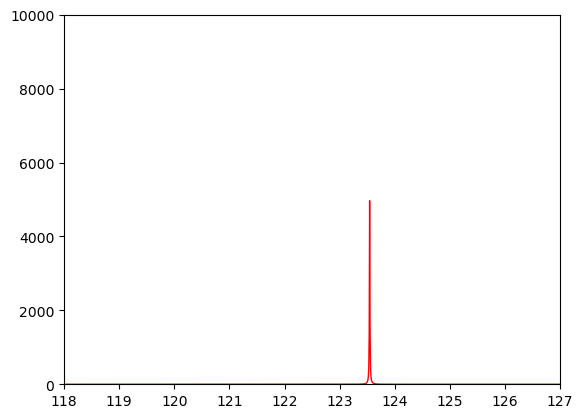

In [16]:
#plot the lorentzian model
# plt.plot(freq, power, color='black')
plt.plot(freq, lorentzian_model(freq, *best_theta), lw=1, color='red')
plt.xlim(118, 127)
plt.ylim(0, 10000)
# plt.plot(freq,power)
# plt.xlim(1, 150)
# plt.ylim(0, 30e3)
plt.show()

### Corner plot for the fit

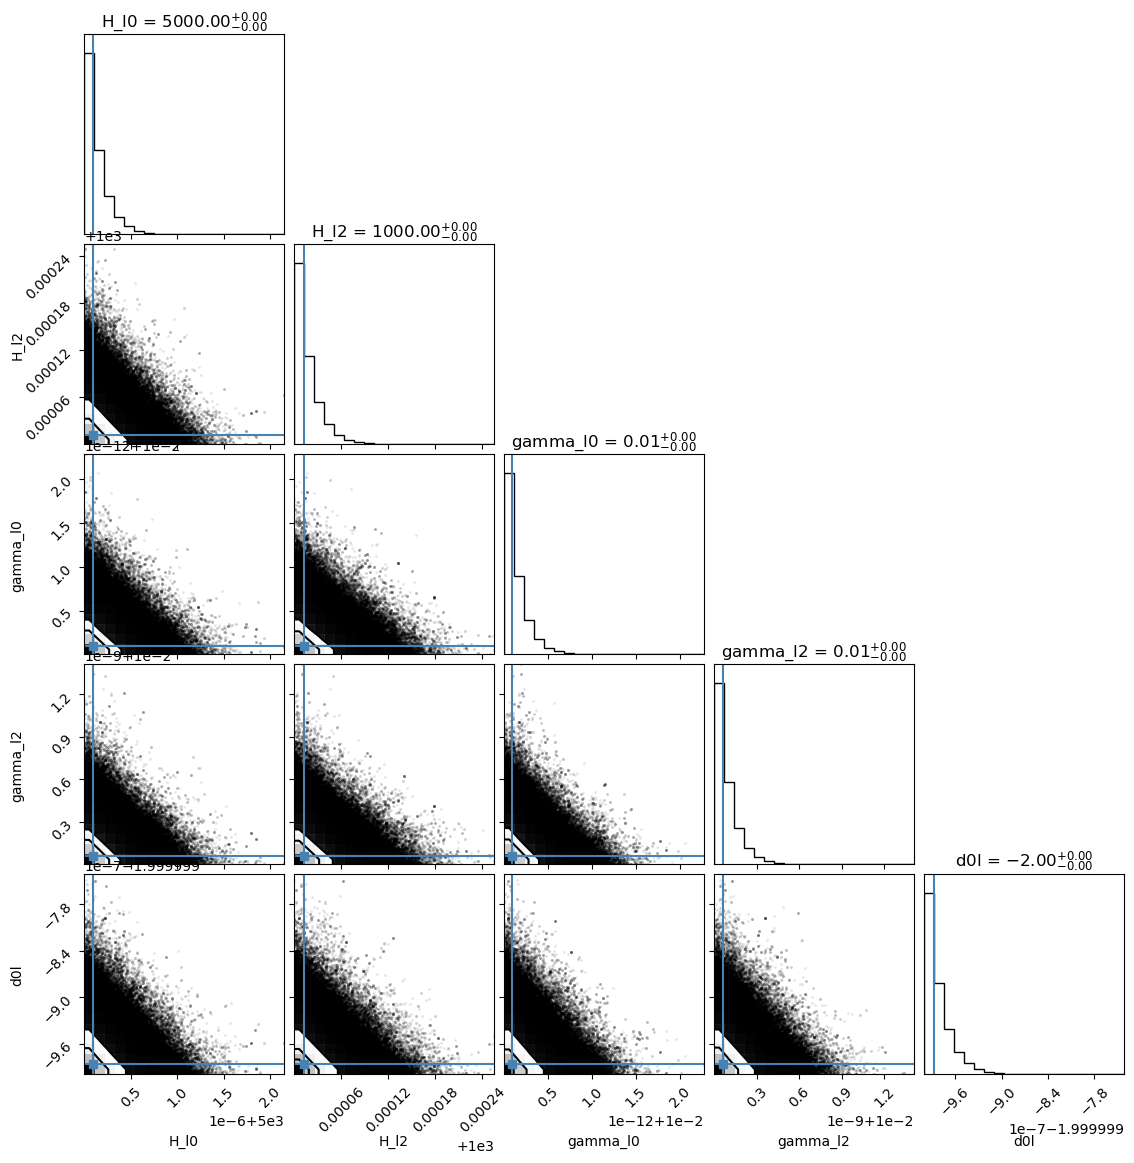

In [13]:
# # plot the corner plot
import corner
fig = corner.corner(samples, labels=["H_l0", "H_l2", "gamma_l0", "gamma_l2", "d0l"], truths=best_theta, show_titles=True)

In [14]:
print(numax)

128.4
